<center>
<h1><b>Text-to-Text tasks with LLMs</b>
</center>

# Objectives

- Illustrate prompt engineering for text-to-text tasks using Llama 2.
- Build and evaluate LLMs for text-to-text tasks using appropriate metrics (e.g., ROUGE score and BERTscore).

# Text $→$ Text generation

A text $→$ text generation task involves the generation of a relevant response to the input depending on the task at hand. Examples include:

 - Summarization (abstractive or extractive)
 - Question Answering (including multiple choice)
 - Matching a premise to a hypothesis

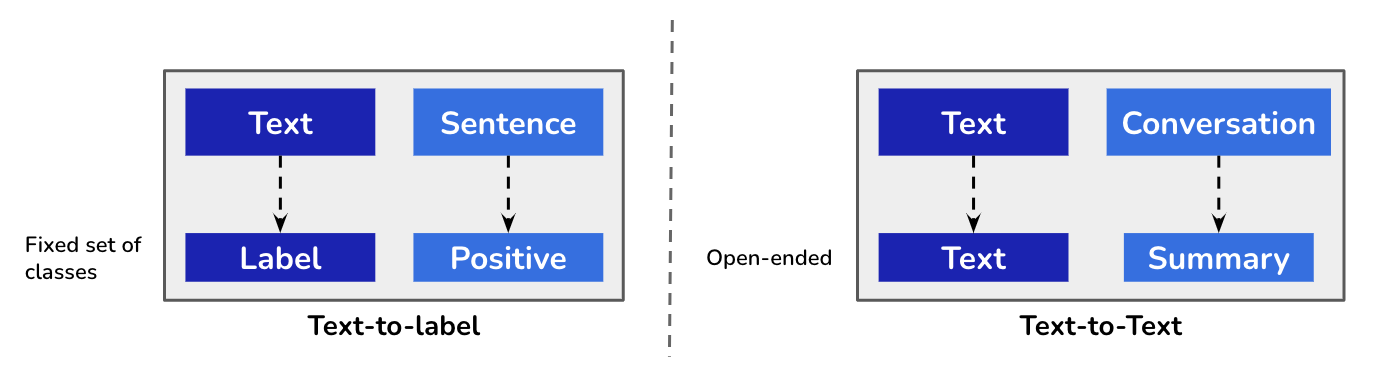

The key thing to note here is that unlike the case of text classification where the labels belong to a known (i.e., pre-defined) set, text-text generation is more abstract. For example, there is no "standard" summary of a customer service request; the quality of summary varies with the human tasked with creating the summary. This lack of standard labels when generating text output given input text complicates the performance evaluation of LLMs on these tasks.

## Operationalizing Generative AI - A Recap

While evaluation of text-to-text tasks requires new evaluation metrics, the overall process of creating a generative AI solution remains the same as that we saw for classification tasks.

Specifically, solutions for text $\rightarrow$ text tasks can be built using LLM machinery using the following steps.

>*Step 1:* Frame the task as a combination of objective and metric.
>
>*Step 2:* Assemble data (i.e., examples and gold examples).
>
>*Step 3:* Design prompts using best practises such as few-shot, CoT, ReAct and evaluate them on gold examples.

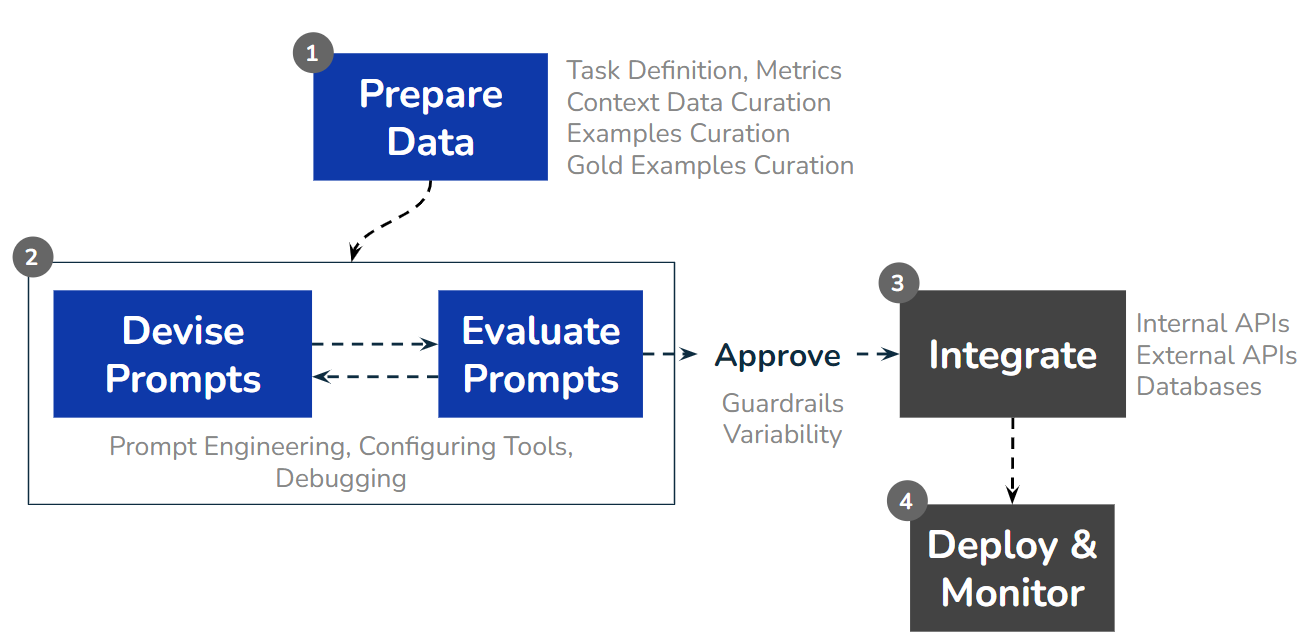

In this notebook, we will take a closer look at two important text $→$ text tasks (summarization and question-answering), setting up the problems, metrics, evaluations with a view to devise prompts that achieve high performance on these evaluations.

In [1]:
#download datasets evaluate rouge_score and bert score
!pip install -q datasets==2.16.1 evaluate==0.4.1 rouge_score==0.1.2 bert_score==0.3.12

DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import json
import numpy as np
import pandas as pd
from datasets import load_dataset
import evaluate
from collections import Counter
from tqdm import tqdm
import torch

## Task 1: Summarization

### Step 1: Define objectives and metrics

There are two methods to summarize input text:
- Abstractive (output: a gist of the input).
- Extractive (output: a selection of key sentences from the input).

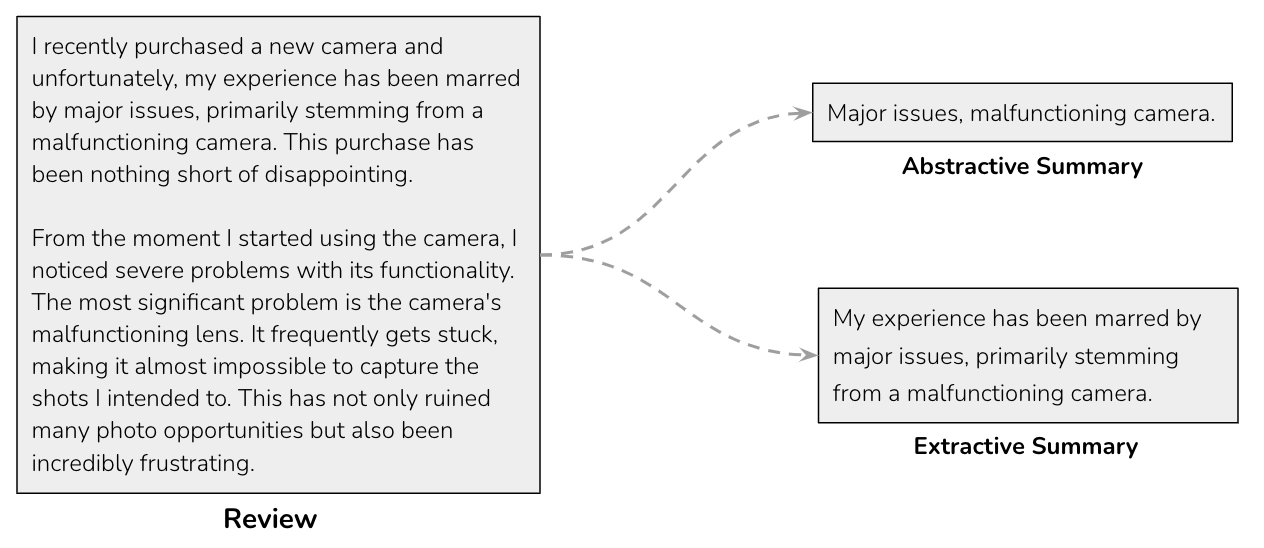

The objective in abstractive summarization is to generate a clear summary of the input text, while that of extractive summarization is to generate a selection of appropriate sentences that summarize the input text.

In order to evaluate model predictions (i.e., AI generated summaries), we compare the model predictions with the ground truth on a sample of human-annotated gold examples. However, given the subjective nature of model predictions, we need new metrics to evaluate summarization outputs: ROUGE Score and BERT Score.

Apart from these this automated metrics, another method used to judge the quality of a summary is to use another LLM to assign a quality rating to the summary. Using an LLM to avaluate another LLM offers further flexibility in evaluation. For example, we could also specify specific attributes of an ideal summary (for e.g., conciseness, clarity of exposition).

Let us now look at each of these metrics in greater detail.

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE)

ROUGE takes a exact match approach to compare the prediction from the model with the human reference summary by relying on matches of n-grams between the two (depicted in the figure below).

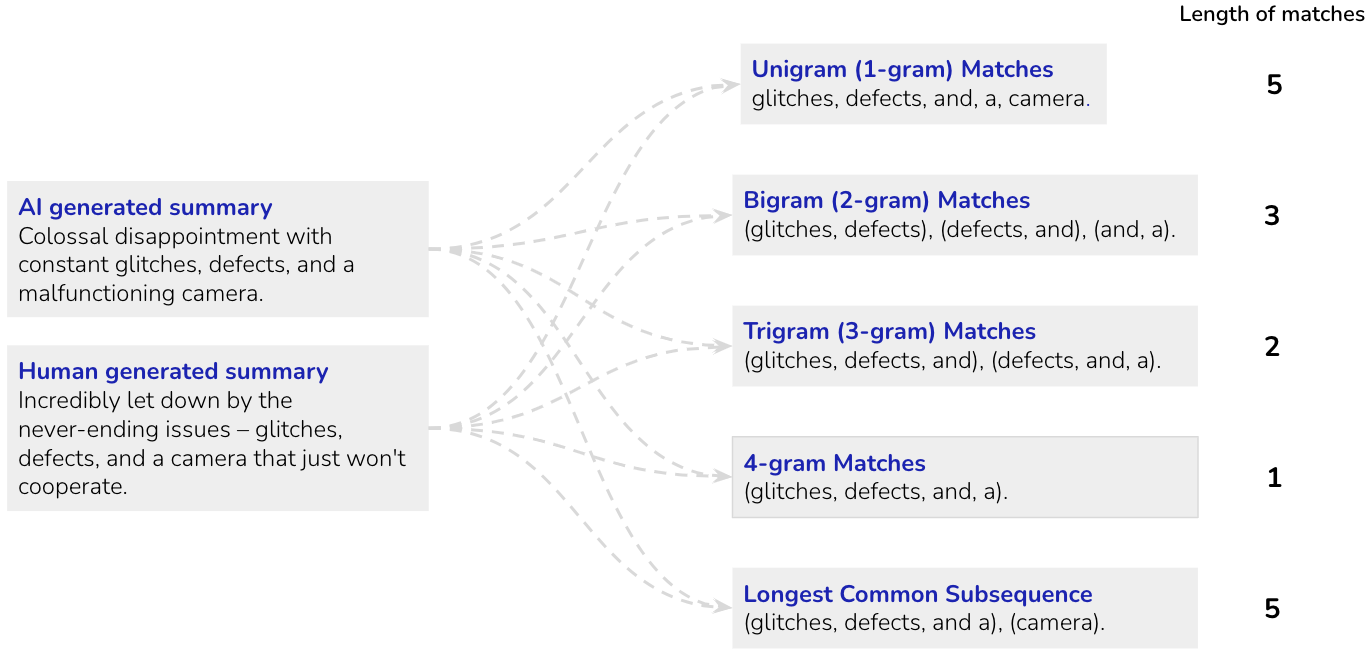

The [$\text{ROUGE}_{N}$](https://huggingface.co/spaces/evaluate-metric/rouge) score is computed using the ratio of the number of n-gram matches to the total number of n-grams in the human generated summary. However, we still have to make a choice whether unigram, bigram, or any other n-gram should be used.

To solve this conundrum, a common variant of ROUGE that is used to generate a comparison metric is $\text{ROUGE}_{\text{L}}$, where we first compute the recall and precision of the longest common subsequence and then compute the harmonic mean of these values (punctuation and case of the word are disregarded).

In [3]:
ai_generated_summary = "Colossal disappointment with constant glitches, defects, and a malfunctioning camera."
human_generated_summary = "Incredibly let down by the never-ending issues – glitches, defects, and a camera that just won't cooperate."

In [4]:
ai_generated_summary = "Alice and Ben boarded a train to Mexico."
human_generated_summary = "Alice and Ben boarded their train to Mexico for vacation."

As seen in the figure above, the length of the largest common subsequence (LCS) between the two summaries is 5. The number of unigrams in the AI-generated summary is 10 and the number of unigrams in the human generated summary is 17.

We define the recall of the LCS as 5/17 and the precision of the LCS as 5/10 (notice the parallel with the precision and recall measures used to evaluate classification tasks).

From these measures, we can compute $\text{ROUGE}_{\text{L}}$ as the F1 score associated with the precision and recall like so:

In [5]:
r_lcs, p_lcs = 7/10, 7/8
(2 * r_lcs * p_lcs)/(r_lcs + p_lcs) # rouge-L

0.7777777777777777

One important limitation of ROUGE is that it accounts for exact matches. This means that a summary that uses semantically close words would receive a poor score despite capturing the intent of the human summary. Hence, ROUGE is usually used for extractive summarization.

ROUGE values close to 1 indicate that the AI-generated text is close to the text generated by a human.

#### BERTScore

BERTScore is ideal in situations where abstractive summarization is the objective (as is in this case). To illustrate the computation of the BERTScore, consider the following two summary outputs (one from a generative AI model and another from a human).

In [6]:
ai_generated_summary = "Major issues, malfunctioning camera."
human_generated_summary = "Severely disappointed, constant problems."

In [7]:
print(ai_generated_summary)
print(human_generated_summary)

Major issues, malfunctioning camera.
Severely disappointed, constant problems.


Look at the two summaries presented above. Though the choice of words is not exactly the same, both are close in intent. In order to capture intent, we use specific models that encode the semantic meaning of words used in the models in a mathematical space where we can measure the distance between the words used. Since distances can be computed, if two words are close to each other in this mathematical space (i.e., less distance), we can infer that these two words are close in meaning.

Models that encode this mapping, that is, models that associate words with a list of numbers (called *vectors*) that define positions of the words in a mathematical space are referred to as [*embedding models*](https://projector.tensorflow.org/). Embedding models are precursors to language models and are a crucial component of how we represent the semantic meaning of words used in text.

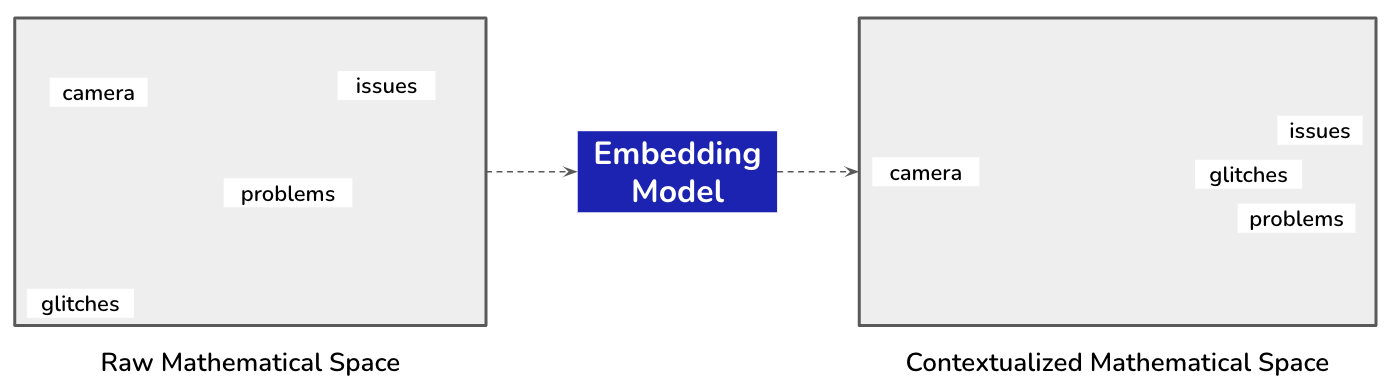

BERTScore uses one such pre-trained embedding model (i.e., Bi-directional Encoder Representation from Transformers - BERT) to:
- map individual words in sentences (in both the AI summary and the human summary) to vectors.
- compute pairwise similarity between all possible pairs of words using these vectors.

Once pairwise similarities are estimated, we use these similarities to compute precision and recall for each word as demonstrated in the following figure.

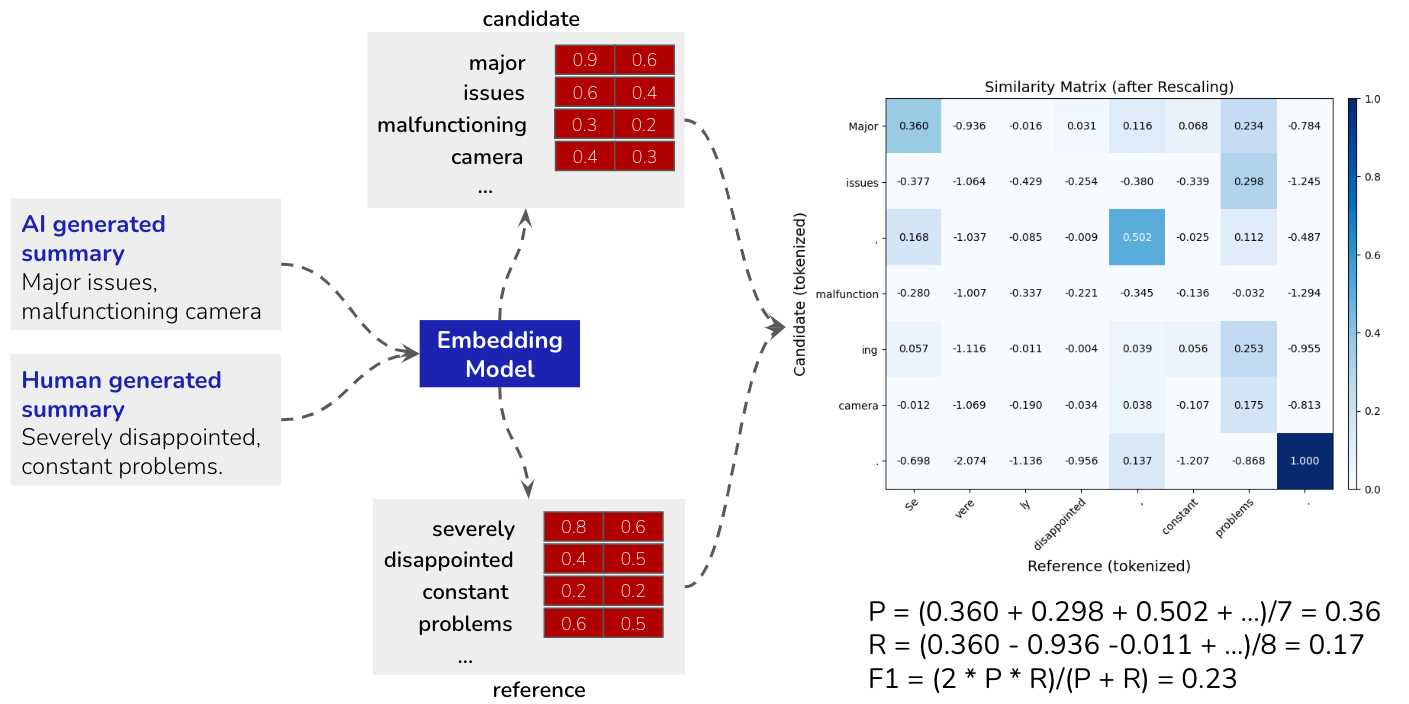

As seen in the figure above, the candidate text (i.e., the AI-generated summary) and the reference text (i.e., the human generated summary) are tokenized and assigned a numeric representation. In this representation, tokens that are correlated with each other lie close to each other (in the space defined by the numeric representation). All pairwise correlations between the tokens of the candidate and the reference are then collected in a table.

For precision ($P$), we average the maximum correlation scores for each token in the *candidate*. For recall ($R$), we average the maximum correlation scores for each token in the *reference*. The F1 score is estimated as: $(2 \times P \times R)/(P+ R)$.

We report the F1 score as the BERTScore. As with ROUGE, BERTScores close to 1 are considered ideal (i.e., the AI-generated text is close to one that is produced by a human).

In [8]:
bert_scorer = evaluate.load("bertscore")

In [9]:
bert_scorer.compute(
    predictions=[ai_generated_summary],
    references=[human_generated_summary],
    lang="en",
    rescale_with_baseline=True
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.48950478434562683],
 'recall': [0.44089406728744507],
 'f1': [0.46595799922943115],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.43.3)-rescaled'}

#### LLM rating LLM output

Another commonly used method to automate evaluations is to use a different model (e.g., GPT-4, LLaMA2) to evaluate the output from the model used to execute the text-to-text task (in this case GPT-3.5). The figure below illustrates the steps involved for the case where a summary is generated for the input text.

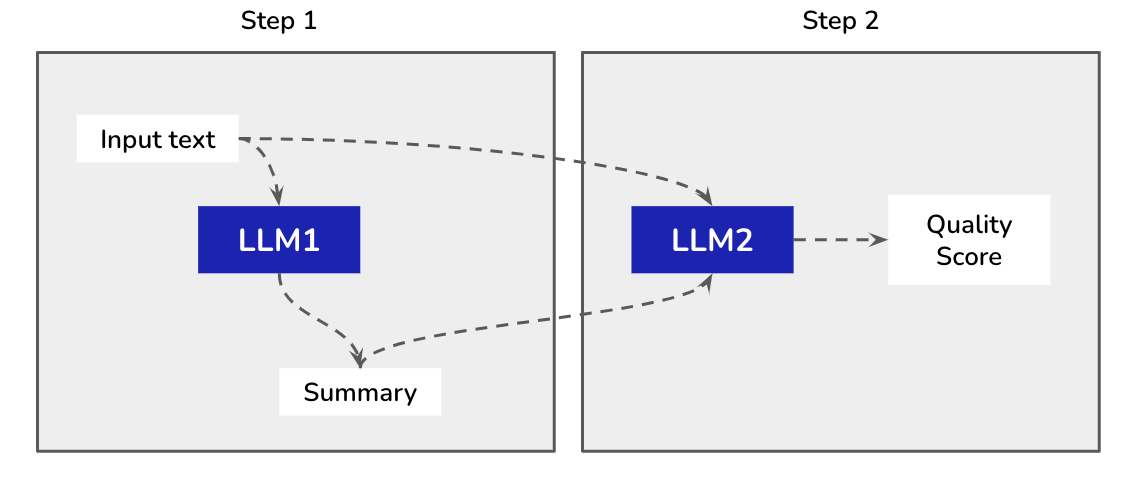

Approaches to using an LLM to evaluate the output of another LLM is an active area of research and initiatives to build standards are still nascent (e.g., [Open AI Evals](https://github.com/openai/evals), [LangChain Evaluators](https://python.langchain.com/docs/guides/evaluation/string/) and [RAGAs](https://github.com/explodinggradients/ragas)).

As an example, consider that we are using an LLM to summarize customer reviews (as is the case in the examples for ROUGE and BERTScore). The following system message and the user message template could be used to prompt a 'rating' LLM based on the output of the 'summarization' LLM.

In [10]:
import json
import numpy as np
import pandas as pd
from datasets import load_dataset
import evaluate
from collections import Counter
from tqdm import tqdm
import torch

In [13]:
from llama_cpp import Llama

In [11]:
llama_path = "/home/ubuntu/models/llama-2-13b-chat.Q5_K_M.gguf"

In [14]:
lcpp_llm = Llama(
        model_path=llama_path,
        n_threads=2,  # CPU cores
        n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
        n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
        n_ctx=4096,  # Context window
    )

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /home/ubuntu/models/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_coun

In [15]:
def generate_prompt(system_message,user_input):
    prompt=rater_user_message_template.format(system_message=system_message,user_message=user_input)
    return prompt

In [16]:
def generate_llama_response(user_message):
    #create prompt
    prompt=generate_prompt(system_message,user_message)
    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=512,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        echo=False
    )

    # Extract and return the response text
    response_text = response["choices"][0]["text"]
    return response_text


In [17]:
system_message = """
You are tasked with rating AI-generated summaries of customer reviews.
You will be presented a review and an AI generated summary of the review as the input.
In the input, the review will begin with ###Review while the AI generated summary will begin with ###Summary.

Instructions:
1. Carefully observe the review and its AI-generated summary presented in the input
2. Rate the quality of the summary generated by the AI system on a scale of 1 to 5, 1 being low quality and 5 being high quality.
Note that the AI system was asked to generate a concise summary reflecting the most important points mentioned in the review.
In your rating, focus your assessment only on whether the summary was an accurate, concise reflection of key points in the review.

Please do not explain your rating, the output should only be the rating between 1 to 5.
"""

In [18]:
customer_review = """
I recently purchased a new camera and unfortunately, my experience has been marred by major issues, primarily stemming from a malfunctioning camera. This purchase has been nothing short of disappointing.

From the moment I started using the camera, I noticed severe problems with its functionality. The most significant problem is the camera's malfunctioning lens. It frequently gets stuck, making it almost impossible to capture the shots I intended to. This has not only ruined many photo opportunities but also been incredibly frustrating.

Additionally, the camera's autofocus system seems to be erratic, often struggling to focus properly, resulting in blurry and unusable images. This issue, combined with the lens problem, has made photography a frustrating and unreliable endeavor.

The camera's battery life is also below par, and I find myself constantly needing to recharge it, which is inconvenient when I'm on the go.

Overall, my experience with this camera has been highly unsatisfactory due to the major issues, primarily the malfunctioning camera, which has made it difficult to capture quality photos. I'm now considering contacting customer support to address these issues, but I can't help but feel disappointed with this purchase.

"""

In [19]:
ai_generated_summary = "Major issues, malfunctioning camera."

In [20]:
rater_user_message_template = f"""
###Review
{customer_review}

###Summary
{ai_generated_summary}
"""

In [21]:
response = generate_llama_response(customer_review)
print(response)


llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      19.26 ms /    38 runs   (    0.51 ms per token,  1973.41 tokens per second)
llama_print_timings: prompt eval time =     568.27 ms /   304 tokens (    1.87 ms per token,   534.95 tokens per second)
llama_print_timings:        eval time =    1884.25 ms /    37 runs   (   50.93 ms per token,    19.64 tokens per second)
llama_print_timings:       total time =    2494.75 ms /   341 tokens


- Lens gets stuck frequently 
- Autofocus system is erratic and unreliable
- Battery life is below par
Overall unsatisfactory experience


### Step 2: Assemble data

With the objective and metrics out of the way, let us now assemble the data for this use case. As in the case text classification, a dataset is a task-specific subset of a corpus.

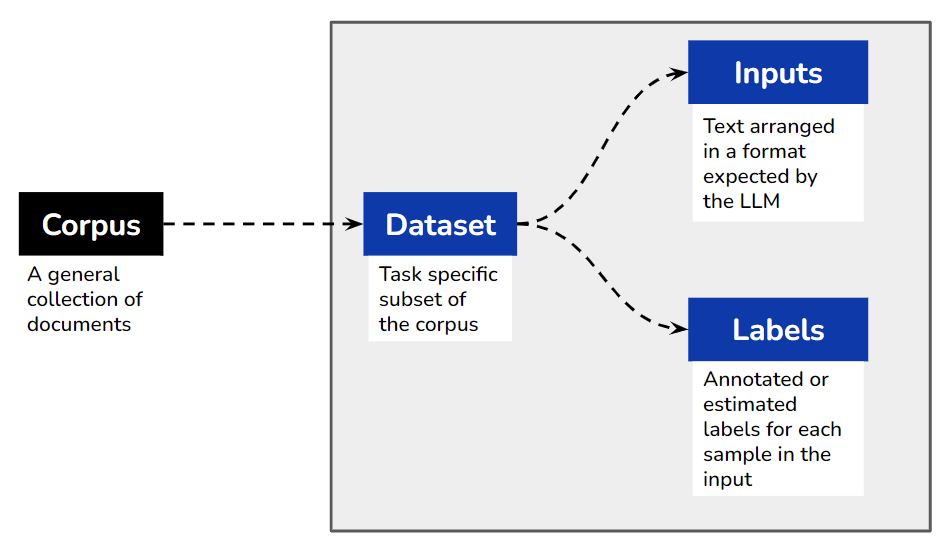

The key difference here is that the labels are not drawn from a predefined distribution. Construction of labels for text $→$ text tasks involves more effort, usually requiring multiple labelers that [brings its own challenges](https://www.databricks.com/blog/2023/04/12/dolly-first-open-commercially-viable-instruction-tuned-llm).

For the abstractive summarization exercise, we use a [dataset of conversations and their summaries](https://huggingface.co/datasets/knkarthick/dialogsum), where each dialogue was summarized by a human. These dialogues belong to a wide variety of topics (7434 in total). We use this dataset to showcase how custom datasets should be prepared and used for prompt engineering.

In [22]:
dataset = load_dataset("knkarthick/dialogsum")

Generating train split: 0 examples [00:00, ? examples/s]

/home/ubuntu/.local/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating validation split: 0 examples [00:00, ? examples/s]

/home/ubuntu/.local/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

/home/ubuntu/.local/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


In [23]:
len(dataset['train'])

12460

In [24]:
dialogue_summary_train_df = dataset['train'].to_pandas()

In [25]:
dialogue_summary_train_df.sample(5)

,id,dialogue,summary,topic
149,train_149,#Person1#: Take a seat inside and see what you...,#Person2# wants to rent a Porsche with the ins...,rent a car
7804,train_7804,#Person1#: I'm sorry to make you wait. What di...,#Person1# persuades #Person2# to buy the 'Love...,go shopping
4793,train_4793,"#Person1#: Ben, come here! I'm having trouble ...",#Person1# asks Ben to help her pick out a dres...,pick out a dress
10794,train_10794,"#Person1#: excuse me, is this the way to the G...",#Person1# is going to the Great Wall but is in...,giving directions
1867,train_1867,"#Person1#: Good afternoon, Steven. Are you com...",Steven apologizes for missing the experiment b...,social talk


In [26]:
dialogue_summary_train_df.topic.value_counts()

topic
shopping               174
job interview          161
daily casual talk      125
phone call              89
order food              79
                      ... 
Overseas travelling      1
Own house                1
Seat exchange            1
Buying a watch           1
join the library         1
Name: count, Length: 7434, dtype: int64

As we did for classification tasks, let us split the training data into two subsets - a 80% subset from which we draw the few-shot examples and a 20% subset from which we draw the gold examples.

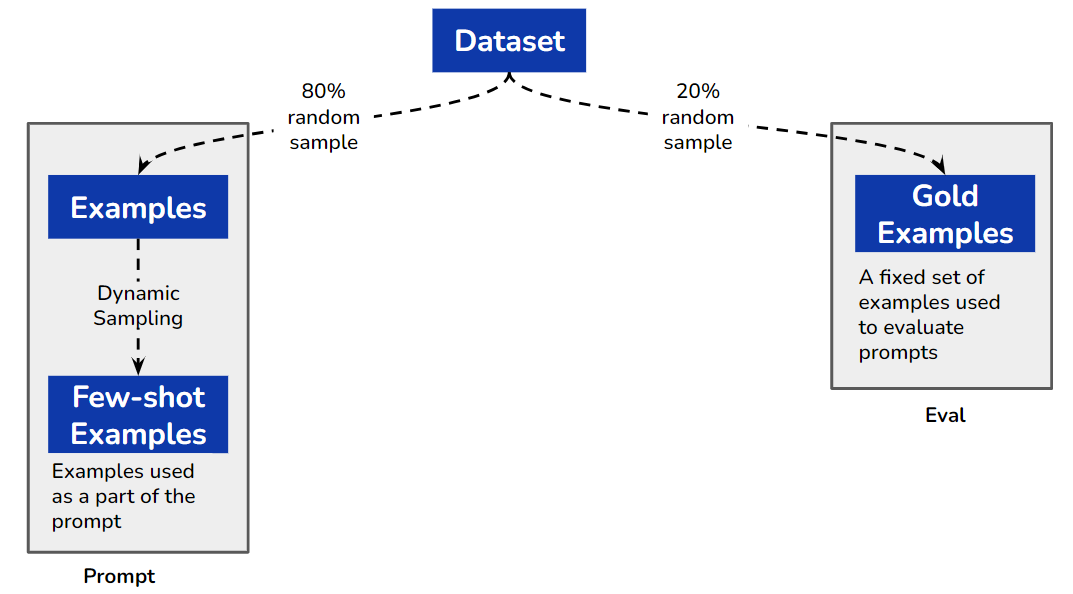

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
dialogue_summary_examples_df, dialogue_summary_gold_examples_df = train_test_split(
    dialogue_summary_train_df, #<- the full dataset
    test_size=0.2, #<- 20% random sample selected for gold examples
    random_state=42 #<- ensures that the splits are the same for every session
)

In [29]:
columns_to_select = ['dialogue', 'summary']

gold_examples = (
    dialogue_summary_gold_examples_df.loc[:, columns_to_select]
                                     .sample(10, random_state=42) # ensures that the gold examples are the same between sessions
                                     .to_json(orient='records')
)

Let us sample 10 gold examples that will be held fixed for prompt evaluation (as depicted in the figure above). Note that we are doing this only only for illustration. In practise, large number of gold examples facilitate robust estimates of model performance.

In [30]:
len(json.loads(gold_examples))

10

In [31]:
json.loads(gold_examples)[0]

{'dialogue': "#Person1#: Good afternoon Miss, would you be interested in buying more life insurance? You know, you can never get enough.\n#Person2#: I think my husband has some.\n#Person1#: Are you sure he ' s purchased enough insurance for both of you? If something terrible happened with your husband, and he doesn ' t have sufficient insurance, my company does have a policy that could cover you and your husband if something happened to either of you.\n#Person2#: That ' s true. If something happened to my husband, I might lose everything. Both of us have to work to keep our home, car, and our children ' s education. I can ' t afford that by myself.\n#Person1#: Could we sit and look at the policy I mentioned and see if that ' s something suitable for you and your husband?\n#Person2#: Certainly.",
 'summary': "#Person1# recommends #Person2# to buy more life insurance. Even though #Person2#'s husband has some, those insurances can't cover both of them. #Person1#'ll show #Person2# the poli

### Step 3: Derive prompt

In [32]:
llama_first_turn_template = """[INST]\n <<SYS>> \n {system_message} \n <</SYS>>```{user_input}``` /n [/INST] \n{assistant_summary}\n</s> """
llama_examples_template = """[INST]\n ```{user_input}``` \n [/INST] \n {assistant_summary}\n</s>"""
llama_prediction_template = """[INST]\n ```{user_input}```[/INST]"""

In [33]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

With the system message in place, we can now assemble a few-shot prompt. Notice how the construction of the few-shot prompt mirrors the function we created for classificiation tasks.

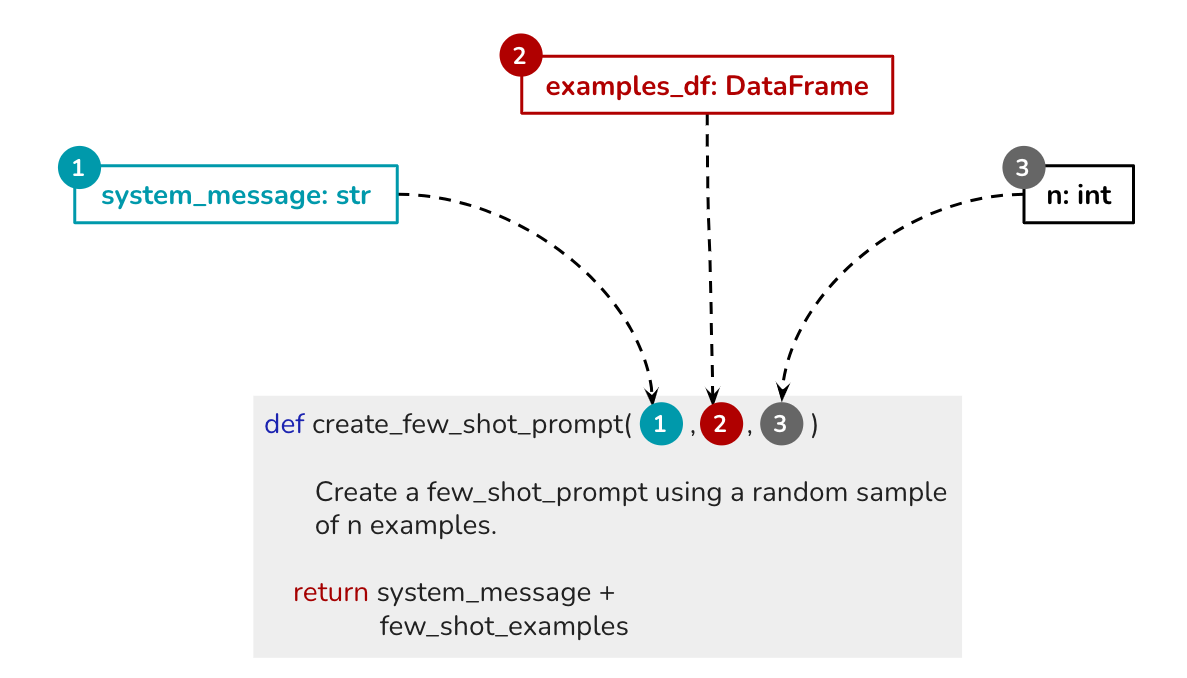

In [34]:
def create_few_shot_prompt(system_message, examples_df,n=8):

    """
    Return a prompt message in the format expected by Llama 2.
    Loop through the examples and parse them as user message and assistant
    output.

    Args:
        system_message (str): system message with instructions for sentiment analysis
        examples (str): JSON string with list of examples
        user_message_template (str): string with a placeholder for movie reviews

    Output:
        few_shot_prompt (str) : a string containing system message, user input and assistant output examples.
    """
    few_shot_prompt = ''
    examples = (
        examples_df.loc[:, columns_to_select]
                   .sample(n)
                   .to_json(orient='records')
    )

    for idx, example in enumerate(json.loads(examples)):
        user_input_example = example['dialogue']
        assistant_output_example = example['summary']

        if idx == 0:
            few_shot_prompt += llama_first_turn_template.format(
                system_message=system_message,
                user_input=user_input_example,
                assistant_summary=assistant_output_example
            )
        else:
            few_shot_prompt += llama_examples_template.format(
                user_input=user_input_example,
                assistant_summary=assistant_output_example
            )

    return few_shot_prompt

Each time this function is executed, a new set of examples is sampled and a prompt is created.

In [35]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

We can see that the number of tokens in quite high in the few-shot prompt. This is because of the long conversations used within the few-shot examples.

While we now have a few-shot prompt assembled, we will still need to ascertain that there is little variability in the performance of this prompt (i.e., the BERTScores or ROUGE-L have less variance).

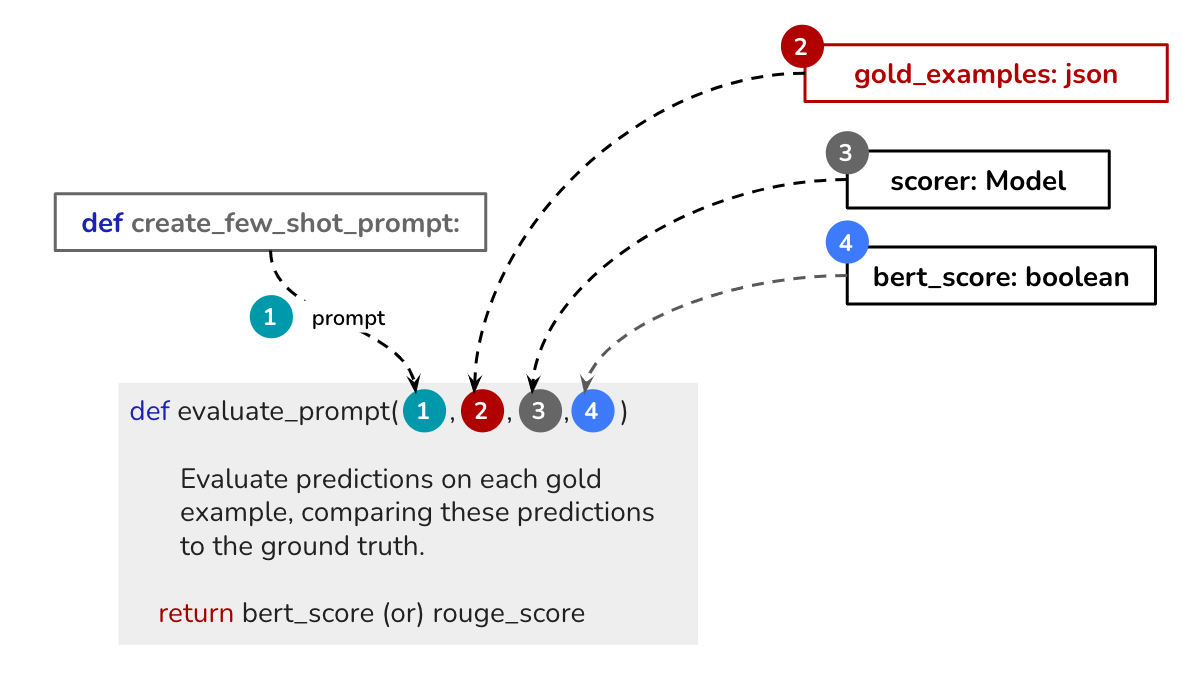

In [36]:
def evaluate_prediction(prompt, gold_examples):

    """
    Return a dictionary of ground truths and model prediction.
    For each example, we make a prediction using the prompt.  Actual sentiments and
    model predictions are aggregated into a dictionary

    Args:
        prompt (str) : a string containing system message, user input and assistant output examples.
        gold_examples (str): JSON string with list of gold examples
        user_message_template (str): string with a placeholder for movie reviews

    Output:
        result (dictionary): actual sentiments and
    model predictions are aggregated into a dictionary
    """

    model_predictions, ground_truths = [], []
    for example in json.loads(gold_examples):
        gold_dialogue = example['dialogue']
        user_input = llama_prediction_template.format(
            user_input=gold_dialogue,
            assistant_message=''
        )

        try:
            response = lcpp_llm(
                prompt=prompt+user_input,
                max_tokens=128,
                temperature=0,
                top_p=0.95,
                repeat_penalty=1.2,
                echo=False # do not return the prompt
            )

            prediction = response["choices"][0]["text"]

            model_predictions.append(prediction)
            ground_truths.append(example['summary'])


        except Exception as e:
            print(e) # Log error and continue
            continue

    return {'model_predictions':model_predictions, 'ground_truths':ground_truths}

In [37]:
result = evaluate_prediction(
    few_shot_prompt,
    gold_examples
)

Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      19.42 ms /    38 runs   (    0.51 ms per token,  1956.64 tokens per second)
llama_print_timings: prompt eval time =    3697.40 ms /  2069 tokens (    1.79 ms per token,   559.58 tokens per second)
llama_print_timings:        eval time =    2128.99 ms /    37 runs   (   57.54 ms per token,    17.38 tokens per second)
llama_print_timings:       total time =    5875.27 ms /  2106 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      17.87 ms /    35 runs   (    0.51 ms per token,  1958.81 tokens per second)
llama_print_timings: prompt eval time =     234.68 ms /   108 tokens (    2.17 ms per token,   460.20 tokens per second)
llama_print_timings:        eval time =    1941.76 ms /    34 runs   (   57.11 ms per token,    17.51 tokens per second)
llama_print_timings:       to

In [38]:
print(result)

{'model_predictions': [' \n #Person1#, an insurance agent, offers to sell more life insurance to #Person2#, who is concerned about losing everything if her husband were to pass away.', '  #Person1# asks if #Person2# felt the earthquake in the afternoon, and they discuss helping the victims by donating clothes and food.', '  #Person1# wishes #Person2# a Happy New Year and asks about their plans for the day. #Person2# mentions going to the parade and church with their father.', ' \n #Person1# asks if #Person2# has any friends in London, and #Person2# mentions that an old friend named Hanson lives there and works as a lawyer.', ' \n #Person1# asks #Person2# to help move some heavy items to the car, but #Person2# declines because he is already running late for an appointment with Mr. Jason.', ' \n #Person1# confesses his love to #Person2#, but #Person2# is not ready for it and asks him to stop.', '  #Person1# and #Person2# have different opinions on what makes a good movie.', " \n #Person1

In [39]:
def evaluate_score(result, scorer, bert_score=False):

    """
    Return the ROUGE score or BERTScore for predictions on gold examples
    For each example we make a prediction using the prompt.
    Gold summaries and the AI generated summaries are aggregated into lists.
    These lists are used by the corresponding scorers to compute metrics.
    Since BERTScore is computed for each candidate-reference pair, we take the
    average F1 score across the gold examples.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        scorer (function): Scorer function used to compute the ROUGE score or the
                           BERTScore
        bert_score (boolean): A flag variable that indicates if BERTScore should
                              be used as the metric.

    Output:
        score (float): BERTScore or ROUGE score computed by comparing model predictions
                       with ground truth
    """

    model_predictions = result['model_predictions']
    ground_truths = result['ground_truths']
    if bert_score:
        score = scorer.compute(
            predictions=model_predictions,
            references=ground_truths,
            lang="en",
            rescale_with_baseline=True
        )

        return sum(score['f1'])/len(score['f1'])
    else:
        return scorer.compute(
            predictions=model_predictions,
            references=ground_truths
        )

In [40]:
rouge_scorer = evaluate.load("rouge")
bert_scorer = evaluate.load("bertscore")

In [41]:
evaluate_score(
    result,
    rouge_scorer
)

{'rouge1': np.float64(0.2926174797667671),
 'rouge2': np.float64(0.09318020033991711),
 'rougeL': np.float64(0.22506577221505952),
 'rougeLsum': np.float64(0.22365112929473846)}

In [42]:
evaluate_score(result,
    bert_scorer,
    bert_score=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.3822251096367836

Note that the metric we need is [$\text{ROUGE}_L$](https://huggingface.co/spaces/evaluate-metric/rouge) that computes the ROUGE score for the longest common subsequence.

Since this is abstractive summarization, we focus on BERTScore as the evaluation metric. In this example, we get a BERTScore with a set of 8 examples chosen at random from the training data to form the few-shot prompt. However, this is *one* choice of examples; we will need to run this evaluation multiple times to capture the variation in performance due to variation in the choice of few-shot examples.

As an example, let us run the evaluations 2 times, each time evaluating the model on BERTScore.

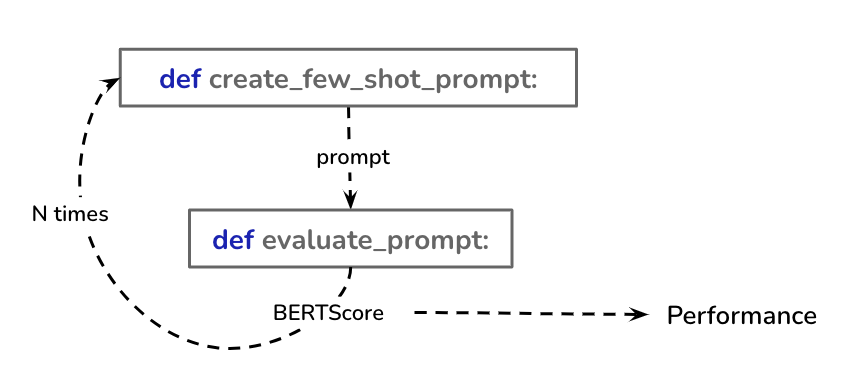

**Reminder: The following code should be run on a GPU runtime to avoid long running times**

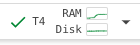

In [43]:
num_eval_runs = 2

In [44]:
few_shot_prediction = []

In [45]:
for _ in tqdm(range(num_eval_runs)):

    # For each run, create a new set of examples and compose the few-shot
    # prompt.
    few_shot_prompt = create_few_shot_prompt(
        system_message,
        dialogue_summary_examples_df
    )

    # Compute BERTScore for the prompt assembled.
    # Gold examples remain the same for each evaluation.
    few_shot_predictions = evaluate_prediction(
        few_shot_prompt,
        gold_examples
    )

    few_shot_prediction.append(few_shot_predictions)

  0%|                                                                           | 0/2 [00:00<?, ?it/s]Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      27.95 ms /    54 runs   (    0.52 ms per token,  1931.75 tokens per second)
llama_print_timings: prompt eval time =    3882.37 ms /  2174 tokens (    1.79 ms per token,   559.97 tokens per second)
llama_print_timings:        eval time =    3121.00 ms /    53 runs   (   58.89 ms per token,    16.98 tokens per second)
llama_print_timings:       total time =    7070.99 ms /  2227 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      22.72 ms /    44 runs   (    0.52 ms per token,  1936.36 tokens per second)
llama_print_timings: prompt eval time =     239.91 ms /   108 tokens (    2.22 ms per token,   450.16 tokens per second)
llama_print_timings:        eval time =    2497.

In [46]:
few_shot_performance=[]

In [47]:
for i in few_shot_prediction:
  score =evaluate_score(i,
    bert_scorer,
    bert_score=True)
  few_shot_performance.append(score)

In [48]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(np.float64(0.36745887994766235), np.float64(0.0004058152437210194))

Once we identify the correct prompt (in this case, it would amount to running variations of the system message prompt), we need to conduct the two sensitivity checks we saw in the case of text $→$ label tasks.

*Check 1: Bias*

We check if the prompt is generating a biased response by presenting a content free input (usually a blank, the string nothing or N/A). This check also acts as a guardrail for the situation where customer input is improperly received.

In [49]:
bias_test_predictions = []

In [50]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

In [51]:
for _ in tqdm(range(5)):

    user_input = """' '"""
    prediction = generate_llama_response(user_input)

    bias_test_predictions.append(prediction)

  0%|                                                                           | 0/5 [00:00<?, ?it/s]Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      19.92 ms /    38 runs   (    0.52 ms per token,  1907.53 tokens per second)
llama_print_timings: prompt eval time =     545.06 ms /   303 tokens (    1.80 ms per token,   555.91 tokens per second)
llama_print_timings:        eval time =    1909.42 ms /    37 runs   (   51.61 ms per token,    19.38 tokens per second)
llama_print_timings:       total time =    2495.90 ms /   340 tokens
 20%|█████████████▍                                                     | 1/5 [00:02<00:10,  2.50s/it]Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      19.71 ms /    38 runs   (    0.52 ms per token,  1928.15 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 token

In [52]:
Counter(bias_test_predictions)

Counter({'- Lens gets stuck frequently \n- Autofocus system is erratic and unreliable\n- Battery life is below par\nOverall unsatisfactory experience': 5})

At best, the model should identify that no dialogue was presented to summarize. At least, it should not give different summaries each time.

*Check 2: Sensitity to number of examples*

To check if the performance of the prompt is sensitive to the number of examples used in the prompt, we vary the number of examples and ascertain that there is no dramatic difference in performance.

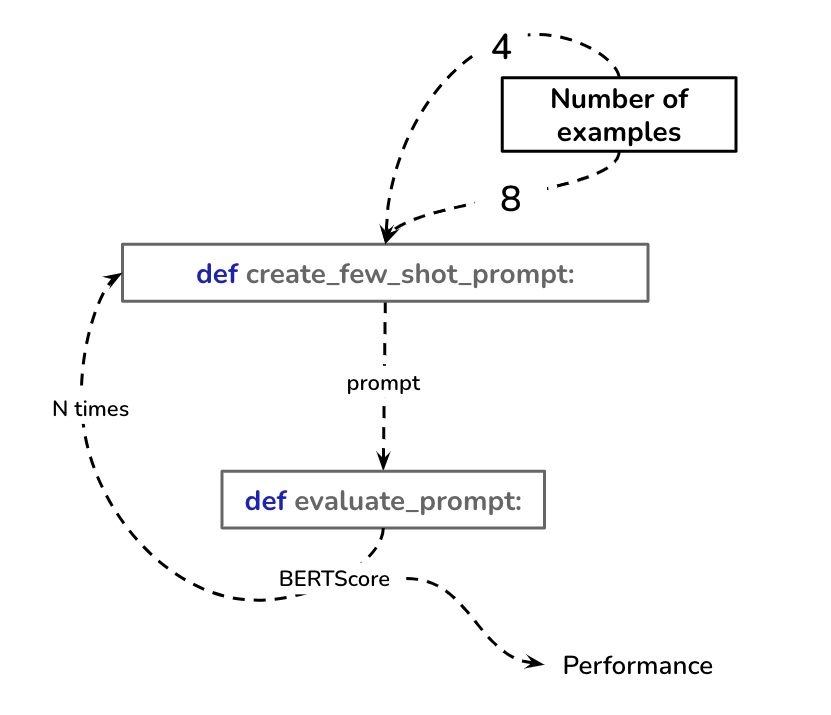

Note that using large number of examples impacts the cost of inference (we pay by token), so we should increase examples only if they have a substantial impact on performance.

In [53]:
sensitivity_results = []
num_examples_choice = [4, 8]

In [54]:
for n in tqdm(num_examples_choice):

    for _ in range(5):

        few_shot_prompt = create_few_shot_prompt(
            system_message,
            dialogue_summary_examples_df,
            n
        )
        sensitivity_predictions = evaluate_prediction(
        few_shot_prompt,
        gold_examples)
        sensitivity_results.append(sensitivity_predictions)


  0%|                                                                           | 0/2 [00:00<?, ?it/s]Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      17.75 ms /    34 runs   (    0.52 ms per token,  1915.60 tokens per second)
llama_print_timings: prompt eval time =    1573.50 ms /   921 tokens (    1.71 ms per token,   585.32 tokens per second)
llama_print_timings:        eval time =    1750.88 ms /    33 runs   (   53.06 ms per token,    18.85 tokens per second)
llama_print_timings:       total time =    3364.73 ms /   954 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     568.67 ms
llama_print_timings:      sample time =      23.77 ms /    46 runs   (    0.52 ms per token,  1934.97 tokens per second)
llama_print_timings: prompt eval time =     209.72 ms /   108 tokens (    1.94 ms per token,   514.96 tokens per second)
llama_print_timings:        eval time =    2359.

In [55]:
sample_size_sensitivity_results=[]

In [56]:
print(sensitivity_results[0])
print(len(sensitivity_results))

{'model_predictions': ['  #Person1#, an insurance salesperson, offers to help #Person2# purchase more life insurance to protect her family in case of unexpected events.', '  #Person1# asks if #Person2# felt the earthquake in the afternoon, and they discuss the damage caused by the earthquake. They decide to donate clothes and food for the victims.', '  #Person1# wishes #Person2# a Happy New Year and asks about their plans for the day. #Person2# invites #Person1# to join them for the parade and church, offering a costume and explaining that they are going with their father, who enjoys attending church.', '  #Person1# asks if #Person2# has any friends in London, and #Person2# mentions an old friend named Hanson who lives there and works as a lawyer.', '  #Person1# asks for help moving some heavy items to their car, but #Person2# declines due to being late for an appointment with Mr. Jason.', '  #Person1# confesses their love to #Person2#, who initially resists but eventually agrees to ac

In [57]:
for i in range(5):
  score =evaluate_score(sensitivity_results[i],
    bert_scorer,
    bert_score=True)
  sample_size_sensitivity_results.append({'num_examples': num_examples_choice[0], 'Bert_score': score})

In [58]:
for i in range(5,10):
  score =evaluate_score(sensitivity_results[i],
    bert_scorer,
    bert_score=True)
  sample_size_sensitivity_results.append({'num_examples': num_examples_choice[1], 'Bert_score': score})


In [59]:
print(sample_size_sensitivity_results)

[{'num_examples': 4, 'Bert_score': 0.42487330436706544}, {'num_examples': 4, 'Bert_score': 0.44230569899082184}, {'num_examples': 4, 'Bert_score': 0.37289213091135026}, {'num_examples': 4, 'Bert_score': 0.37232146263122556}, {'num_examples': 4, 'Bert_score': 0.39501193463802337}, {'num_examples': 8, 'Bert_score': 0.3926794111728668}, {'num_examples': 8, 'Bert_score': 0.3930677503347397}, {'num_examples': 8, 'Bert_score': 0.38909513503313065}, {'num_examples': 8, 'Bert_score': 0.37310664504766466}, {'num_examples': 8, 'Bert_score': 0.3953613579273224}]


In [60]:
pd.DataFrame(sample_size_sensitivity_results).groupby('num_examples').agg(['mean', 'std'])

Bert_score          
                   mean       std
num_examples                     
4              0.401481  0.031318
8              0.388662  0.008980

As we can see, the BERT Score is not sensitive to the number of examples chosen to be part of the few-shot prompt. This means that we can now release the few-shot prompt for deployment.

If there was a significant difference in BERT Score, we would choose the number of examples with the highest BERT Score to create the few-shot prompt. At the same time, if we observe high variability, this is an indicator that few-shot prompting is not an ideal solution. In this case we will need more context than that embedded within the few-shot examples.